In [1]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
seed = 1
np.random.seed(seed)

n = 20

In [3]:
#mxj = np.array([2,3,2,3,2])
mxj = np.random.randint(2,5,size=n)
#mxj = np.random.randint(3,4,size=n)
print(mxj)

mx = mxj.sum()
print(mx)

my = 3
#l = int(4*(mx*my))
l = int(2*(mx**2))
print(l)

[3 2 2 3 3 2 2 3 2 3 2 4 3 4 2 4 3 4 2 2]
55
6050


In [4]:
l

6050

In [5]:
def generate_interaction(mx,my):
    g = 2.0
    #w = np.random.normal(0,g/np.sqrt(mx*my),size=(mx,my))
    w = np.random.normal(0,g/np.sqrt(mx),size=(mx,my))
    #w -= w.mean(axis=0)[np.newaxis,:] # sum of interactions wji from every j to each state i is 1
    w -= w.mean(axis=1)[:,np.newaxis]
    
    #symmetry
    #for i in range(mx):
    #    for j in range(my):
    #        if j > i: w[i,j] = w[j,i] 
        
    return w

In [6]:
w0 = generate_interaction(mx,my)

In [7]:
h0 = np.zeros(my)
#h0 = np.random.normal(0.0,1./np.sqrt(mx),size=my)
h0 -= h0.mean()
print(h0)

[0. 0. 0.]


In [8]:
x0 = np.hstack([np.random.randint(mxj[j],size=(l,1)) for j in range(n)])
print(x0.shape)

(6050, 20)


In [9]:
onehot_encoder = OneHotEncoder(sparse=False)
x = onehot_encoder.fit_transform(x0)
print(x.shape)
#print(x)

(6050, 55)


In [10]:
y0 = np.random.randint(my,size=l)
print(y0.shape)

onehot_encoder = OneHotEncoder(sparse=False)
y = onehot_encoder.fit_transform(y0[:,np.newaxis])
print(y.shape)

nrepeat = 2*(n*my)
for irepeat in range(nrepeat):
    for i in range(my):
        h = h0[np.newaxis,:] + x.dot(w0)

        k0 = np.argmax(y,axis=1)
        for t in range(l):
            k = np.random.randint(my)                
            while k == k0[t]:
                k = np.random.randint(0,my)

            if np.exp(h[t,k] - h[t,k0[t]]) > np.random.rand():
                y[t,:],y[t,k] = 0.,1.

(6050,)
(6050, 3)


In [11]:
def fit(x,y,nloop=40):    
    #----------------------------------------------------------------
    # covariance[ia,ib]
    cab_inv = np.empty((my,my,mx,mx))
    eps = np.empty((my,my,l))

    for ia in range(my):
        #print(ia)
        for ib in range(my):
            if ib != ia:
                #print(ia,ib)
                eps[ia,ib,:] = y[:,ia] - y[:,ib]

                which_ab = eps[ia,ib,:] !=0.                    
                xab = x[which_ab]          
                # ----------------------------
                xab_av = np.mean(xab,axis=0)
                dxab = xab - xab_av
                cab = np.cov(dxab,rowvar=False,bias=True)
                #print(cab)

                cab_inv[ia,ib,:,:] = linalg.pinv(cab,rcond=1e-15)    
    #----------------------------------------------------------------
    
    w = np.random.normal(0.0,1./np.sqrt(mx),size=(mx,my))
    h0 = np.random.normal(0.0,1./np.sqrt(mx),size=my)
    
    cost = np.full(nloop,100.) 
    for iloop in range(nloop):
        h = h0[np.newaxis,:] + x.dot(w)

        # stopping criterion --------------------
        p = np.exp(h)
        p /= p.sum(axis=1)[:,np.newaxis]

        cost[iloop] = ((y - p)**2).mean()
        if iloop > 1 and cost[iloop] >= cost[iloop-1]: break
        #-----------------------------------------    

        for ia in range(my):
            wa = np.zeros(mx)
            ha0 = 0.
            for ib in range(my):
                if ib != ia:

                    which_ab = eps[ia,ib,:] !=0.

                    eps_ab = eps[ia,ib,which_ab]
                    xab = x[which_ab]

                    # ----------------------------
                    xab_av = xab.mean(axis=0)
                    dxab = xab - xab_av

                    h_ab = h[which_ab,ia] - h[which_ab,ib]

                    which_non_zero = h_ab!=0
                    ha = eps_ab[which_non_zero]*h_ab[which_non_zero]/np.tanh(h_ab[which_non_zero]/2.)

                    dhdx = dxab*((ha - ha.mean())[:,np.newaxis])
                    dhdx_av = dhdx.mean(axis=0)

                    wab = cab_inv[ia,ib,:,:].dot(dhdx_av)   # wa - wb
                    h0ab = ha.mean() - xab_av.dot(wab)      # ha0 - hb0

                    wa += wab
                    ha0 += h0ab

            w[:,ia] = wa/my
            h0[ia] = ha0/my
    return w,h0            

In [12]:
w,h0_infer = fit(x,y,nloop=40)

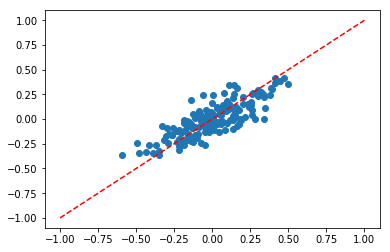

In [15]:
plt.scatter(w0,w)
plt.plot([-1.,1.],[-1.,1.0],'r--')
plt.show()

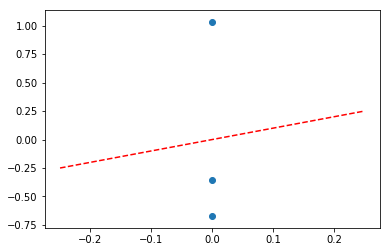

In [16]:
plt.scatter(h0,h0_infer)
plt.plot([-0.25,0.25],[-0.25,0.25],'r--')
plt.show()